<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: West Nile Virus Prediction

---

In [1]:
# import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from collections import Counter

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
import statsmodels.api as sm

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, plot_roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KernelDensity
from IPython.display import Image

sns.set_style('white')
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Data Import

In [2]:
weather = pd.read_csv('./output/weather_cleaned.csv')
spray = pd.read_csv('./output/spray_cleaned.csv')
train = pd.read_csv('./output/train_cleaned.csv')
test = pd.read_csv('./output/test_cleaned.csv')

In [3]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   int64  
 5   Depart       2944 non-null   int64  
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   int64  
 8   Heat         2944 non-null   int64  
 9   Cool         2944 non-null   int64  
 10  Sunrise      2944 non-null   int64  
 11  Sunset       2944 non-null   int64  
 12  CodeSum      2944 non-null   object 
 13  PrecipBool   2944 non-null   int64  
 14  PrecipTotal  2944 non-null   float64
 15  StnPressure  2944 non-null   float64
 16  SeaLevel     2944 non-null   float64
 17  ResultSpeed  2944 non-null   float64
 18  ResultDir    2944 non-null   int64  
 19  AvgSpe

In [4]:
# Convert date to datetime.
weather['Date'] = pd.to_datetime(weather['Date'])

In [5]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14294 entries, 0 to 14293
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        14294 non-null  object 
 1   Latitude    14294 non-null  float64
 2   Longitude   14294 non-null  float64
 3   Month       14294 non-null  int64  
 4   Week        14294 non-null  int64  
 5   Year        14294 non-null  int64  
 6   Year Month  14294 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 781.8+ KB


In [6]:
# Convert date to datetime.
spray['Date'] = pd.to_datetime(spray['Date'])

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9693 entries, 0 to 9692
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    9693 non-null   object 
 1   Address                 9693 non-null   object 
 2   Species                 9693 non-null   object 
 3   Block                   9693 non-null   int64  
 4   Street                  9693 non-null   object 
 5   Trap                    9693 non-null   object 
 6   AddressNumberAndStreet  9693 non-null   object 
 7   Latitude                9693 non-null   float64
 8   Longitude               9693 non-null   float64
 9   AddressAccuracy         9693 non-null   int64  
 10  NumMosquitos            9693 non-null   int64  
 11  WnvPresent              9693 non-null   int64  
 12  Month                   9693 non-null   int64  
 13  Week                    9693 non-null   int64  
 14  Year                    9693 non-null   

In [8]:
train['Date'] = pd.to_datetime(train['Date'])

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
 11  Month                   116293 non-null  int64  
 12  Week                    116293 non-null  int64  
 13  Year                    116293 non-null  int64  
 14  Year Month          

In [10]:
# Convert date to datetime.
test['Date'] = pd.to_datetime(test['Date'])

## Feature Engineering

### Weather -- Sunhour Feature

In [11]:
# change datatypes of Sunrise and Sunset values 
weather['Sunrise'] = weather['Sunrise'].apply(str)
weather['Sunset'] = weather['Sunset'].apply(str)

In [12]:
# convert Sunrise and Sunset values to datetime
sunrise_time = []
for val in weather['Sunrise']:
    date_val = datetime.datetime.strptime(val, '%H%M')
    sunrise_time.append(date_val.hour + date_val.minute/60)

sunset_time = []
for val in weather['Sunset']:
    try:
        date_val = datetime.datetime.strptime(val, '%H%M')
        sunset_time.append(date_val.hour + date_val.minute/60)
    except:
        date_val = datetime.datetime.strptime(val.replace('60', '59'), '%H%M')
        sunset_time.append(date_val.hour + date_val.minute/60)

# convert values to hours from midnight
weather['Sunrise'] = sunrise_time
weather['Sunset'] = sunset_time

In [13]:
# create new column to store sunhours
weather['SunHours'] = weather['Sunset'] - weather['Sunrise']

# drop Sunrise and Sunset columns
weather.drop(columns=['Sunrise', 'Sunset'], inplace=True)

### Weather -- Codesum Feature

Only days with weather condition will be recorded in the dataset. Hence, empty strings in this column actually means that it is a weather-wise uneventful day. We can replace all empty string with '0' to indicate that.

Specifically, we want to create dummy variables - Rain, Snow, Windy and Misty - as follows:

Rain = 1 if CodeSum contains ['TS', 'RA', 'DZ', 'SH'] else = 0

Snow = 1 if CodeSum contains ['SN', 'SG', 'GS', 'PL', 'IC', 'DR', 'BC', 'GR'] else = 0

Windy = 1 if CodeSum contains ['SQ', 'DS', 'SS', 'PO', 'BL'] else = 0

Misty = 1 if CodeSum contains ['BR', 'HZ', 'FG', 'FU'] else = 0

In [14]:
weather["CodeSum"].unique()

array([' ', 'BR', 'BR HZ', 'HZ', 'RA', 'RA BR', 'TSRA RA BR', 'RA VCTS',
       'TSRA RA', 'RA HZ', 'TSRA RA BR HZ', 'TSRA BR HZ', 'RA BR HZ VCTS',
       'TSRA RA HZ', 'TSRA BR HZ VCTS', 'TSRA', 'TSRA BR HZ FU',
       'TSRA RA HZ FU', 'BR HZ FU', 'TSRA RA VCTS', 'HZ VCTS', 'TSRA HZ',
       'VCTS', 'RA BR VCTS', 'TSRA RA BR VCTS', 'TS TSRA RA BR HZ VCTS',
       'DZ BR', 'TS TSRA RA BR HZ', 'TS TSRA BR HZ', 'RA BR HZ',
       'TSRA RA DZ BR HZ', 'TS TSRA RA BR', 'TS RA BR', 'TS TSRA RA',
       'TS TSRA RA BR VCTS', 'TS TSRA BR', 'TS RA', 'RA BCFG BR',
       'TSRA BR', 'RA DZ FG+ BCFG BR', 'RA FG+ MIFG BR', 'RA DZ',
       'RA DZ BR', 'TS TSRA RA HZ', 'TSRA RA FG+ FG BR',
       'TSRA DZ FG+ FG BR HZ', 'TS BR', 'RA BR SQ', 'TS TSRA',
       'TSRA RA BR HZ VCTS', 'BR VCTS', 'TS', 'FG+ BR HZ', 'RA SN',
       'TSRA RA DZ BR', 'DZ BR HZ', 'RA BR FU', 'TS BR HZ', 'DZ',
       'FG+ BR', 'FG+ FG BR', 'FG+ MIFG BR', 'TSRA RA FG BR',
       'TSRA FG+ BR', 'RA DZ BR HZ', 'RA DZ SN', 'FG+ FG 

In [15]:
# Ensuring that each code has proper spacing
codes = ['+FC','FC', 'TS', 'GR', 'RA', 'DZ', 'SN', 'SG', 'GS', 'PL',
         'IC', 'FG+', 'FG', 'BR', 'UP', 'HZ', 'FU', 'VA', 'DU', 'DS',
         'PO', 'SA', 'SS', 'PY', 'SQ', 'DR', 'SH', 'FZ', 'MI', 'PR',
         'BC', 'BL', 'VC']
weather['CodeSum'] = weather['CodeSum'].apply(lambda x: ' '.join([t for t in x.split(' ') if t in codes]))

In [16]:
# create dummy variables indicate rainy, snowy, windy and misty conditions 
weather["Rain"] = np.where(weather['CodeSum'].str.contains("|".join(['TS', 'RA', 'DZ', 'SH'])), 1, 0)
weather["Snow"] = np.where(weather['CodeSum'].str.contains("|".join(['SN', 'SG', 'GS', 'PL', 'IC', 'DR', 'BC', 'GR'])), 1, 0)
weather["Wind"] = np.where(weather['CodeSum'].str.contains("|".join(['SQ', 'DS', 'SS', 'PO', 'BL'])), 1, 0)
weather["Mist"] = np.where(weather['CodeSum'].str.contains("|".join(['BR', 'HZ', 'FG', 'FU'])), 1, 0)

In [17]:
weather.tail()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,CodeSum,PrecipBool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,SunHours,Rain,Snow,Wind,Mist
2939,2,2014-10-29,49,40,45,-2,34,42,20,0,,0,0.00,29.42,30.07,8.5,29,9.0,10.50,0,0,0,0
2940,1,2014-10-30,51,32,42,-4,34,40,23,0,,0,0.00,29.34,30.09,5.1,24,5.5,10.45,0,0,0,0
2941,2,2014-10-30,53,37,45,-1,35,42,20,0,RA,1,0.00,29.41,30.10,5.9,23,6.5,10.45,1,0,0,0
2942,1,2014-10-31,47,33,40,-6,25,33,25,0,RA SN,1,0.03,29.49,30.20,22.6,34,22.9,10.40,1,1,0,0
2943,2,2014-10-31,49,34,42,-4,29,36,23,0,RA SN BR,1,0.04,29.54,30.20,21.7,34,22.6,10.40,1,1,0,1


In [18]:
# now that we have the dummy variables for the key weather conditions, we can drop CodeSum
weather.drop(["CodeSum"], axis=1, inplace=True)

### Weather -- Humidity Feature

Mosquitos tends to grow when the weather is humid. Therefore, we engineer an additional weather feature according to the [reference](https://www.calcunation.com/calculator/humidity-calculator.php).

In [19]:
weather['Humidity'] = np.round(100-25/9*(weather['Tavg']-weather['DewPoint']),1)

In [20]:
weather['Humidity'].describe()

count    2944.000000
mean       61.721603
std        14.349888
min         8.300000
25%        52.800000
50%        61.100000
75%        72.200000
max       105.600000
Name: Humidity, dtype: float64

In [21]:
weather.loc[weather['Humidity']>100,'Humidity'] = 100

### Weather -- Time Lag Feature

From research, we know that the following conditions will affect the mosquitos' ability to survive and breed ([Source: Orkin, 2021](https://www.orkin.com/pests/mosquitoes/when-are-mosquitoes-most-active))

Wind, Temperature, Humidity, Precipitation, Drought & Rainfall

Additionally, the entire life cycle of a mosquito, from an egg to an adult, takes approximately 8-10 days ([Source: CDC, 2021](https://www.cdc.gov/dengue/resources/factsheets/mosquitolifecyclefinal.pdf)). Therefore, we will want to monitor the weather conditions after the past 1, 3, 7 and 14 days.

In [22]:
# split the weather features by stations
weather_df_group1 = weather.loc[weather['Station']==1]
weather_df_group2 = weather.loc[weather['Station']==2]

In [23]:
# create a variable to store the weather features to do a time lag on
weat_features = ['AvgSpeed', 'DewPoint', 'PrecipTotal', 'ResultDir', 'ResultSpeed', 'SeaLevel', 'StnPressure',
                'Tavg', 'WetBulb', 'SunHours', 'Humidity']

group1_lag_features = weather_df_group1[weat_features]
group2_lag_features = weather_df_group2[weat_features]

# set the number of lags in days
lags = (1, 3, 7, 14)

# assign new columns to the respective dataframes
group1_weather_lag_features = weather_df_group1.assign(**{f'{col}_lag_{n}': 
                                                          group1_lag_features[col].shift(n) for n in lags 
                                                          for col in group1_lag_features})

group2_weather_lag_features = weather_df_group2.assign(**{f'{col}_lag_{n}': 
                                                          group2_lag_features[col].shift(n) for n in lags 
                                                          for col in group2_lag_features})

In [24]:
# merge both group1_weather_lag_features and group2_weather_lag_features into one dataframe
weather_new_df = pd.concat([group1_weather_lag_features, group2_weather_lag_features])

### Train --  Mosquito Species

Of all the mosquitoes collected, only those belonging to species groups - Restuans or Pipiens - had tested positive for the virus in the train dataset. Mosquito Species will likely be a useful predictor. We create weightage of 1 by dummifying it.

In [25]:
species = ["PIPIENS", "RESTUANS"]

# create loop to create dummified variables to indicate presence of Pipiens & Restuans species
for i in species:
    train[i] = 0
    for index, row in train.iterrows():
        if i in row["Species"]:
            train[i][index] = 1 

In [26]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Month,Week,Year,Year Month,LatLong,Coord,Nearest_Station,PIPIENS,RESTUANS
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,5,22,2007,2007 05,"(41.95469, -87.800991)",POINT (41.95469 -87.800991),1,1,1
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,5,22,2007,2007 05,"(41.95469, -87.800991)",POINT (41.95469 -87.800991),1,0,1
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,5,22,2007,2007 05,"(41.994991, -87.769279)",POINT (41.994991 -87.769279),1,0,1
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,5,22,2007,2007 05,"(41.974089, -87.824812)",POINT (41.974089 -87.824812),1,1,1
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,5,22,2007,2007 05,"(41.974089, -87.824812)",POINT (41.974089 -87.824812),1,0,1


## Pre-processing

In [27]:
# renamed 'Nearest_Station' to 'Station'
train.rename(columns = {'Nearest_Station': 'Station'}, inplace=True)
test.rename(columns = {'Nearest_Station': 'Station'}, inplace=True)

In [28]:
# merge both train/test and weather datasets
train_weather_df = pd.merge(train, weather_new_df, on=['Date', 'Station'])
test_weather_df = pd.merge(test, weather_new_df, on=['Date', 'Station'])

In [29]:
train_weather_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Month,Week,Year,Year Month,LatLong,Coord,Station,PIPIENS,RESTUANS,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipBool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,SunHours,Rain,Snow,Wind,Mist,Humidity,AvgSpeed_lag_1,DewPoint_lag_1,PrecipTotal_lag_1,ResultDir_lag_1,ResultSpeed_lag_1,SeaLevel_lag_1,StnPressure_lag_1,Tavg_lag_1,WetBulb_lag_1,SunHours_lag_1,Humidity_lag_1,AvgSpeed_lag_3,DewPoint_lag_3,PrecipTotal_lag_3,ResultDir_lag_3,ResultSpeed_lag_3,SeaLevel_lag_3,StnPressure_lag_3,Tavg_lag_3,WetBulb_lag_3,SunHours_lag_3,Humidity_lag_3,AvgSpeed_lag_7,DewPoint_lag_7,PrecipTotal_lag_7,ResultDir_lag_7,ResultSpeed_lag_7,SeaLevel_lag_7,StnPressure_lag_7,Tavg_lag_7,WetBulb_lag_7,SunHours_lag_7,Humidity_lag_7,AvgSpeed_lag_14,DewPoint_lag_14,PrecipTotal_lag_14,ResultDir_lag_14,ResultSpeed_lag_14,SeaLevel_lag_14,StnPressure_lag_14,Tavg_lag_14,WetBulb_lag_14,SunHours_lag_14,Humidity_lag_14
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,5,22,2007,2007 05,"(41.95469, -87.800991)",POINT (41.95469 -87.800991),1,1,1,88,60,74,10,58,65,0,9,0,0.0,29.39,30.11,5.8,18,6.5,14.933333,0,0,0,1,55.6,5.3,47.0,0.0,10.0,4.8,30.15,29.43,65.0,56.0,14.916667,50.0,7.2,55.0,1.01,17.0,2.8,30.11,29.36,57.0,56.0,14.883333,94.4,10.2,46.0,0.0,18.0,10.0,30.06,29.34,71.0,58.0,14.766667,30.6,12.3,56.0,0.38,27.0,8.1,29.84,29.13,69.0,61.0,14.533333,63.9
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,5,22,2007,2007 05,"(41.95469, -87.800991)",POINT (41.95469 -87.800991),1,0,1,88,60,74,10,58,65,0,9,0,0.0,29.39,30.11,5.8,18,6.5,14.933333,0,0,0,1,55.6,5.3,47.0,0.0,10.0,4.8,30.15,29.43,65.0,56.0,14.916667,50.0,7.2,55.0,1.01,17.0,2.8,30.11,29.36,57.0,56.0,14.883333,94.4,10.2,46.0,0.0,18.0,10.0,30.06,29.34,71.0,58.0,14.766667,30.6,12.3,56.0,0.38,27.0,8.1,29.84,29.13,69.0,61.0,14.533333,63.9
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,5,22,2007,2007 05,"(41.994991, -87.769279)",POINT (41.994991 -87.769279),1,0,1,88,60,74,10,58,65,0,9,0,0.0,29.39,30.11,5.8,18,6.5,14.933333,0,0,0,1,55.6,5.3,47.0,0.0,10.0,4.8,30.15,29.43,65.0,56.0,14.916667,50.0,7.2,55.0,1.01,17.0,2.8,30.11,29.36,57.0,56.0,14.883333,94.4,10.2,46.0,0.0,18.0,10.0,30.06,29.34,71.0,58.0,14.766667,30.6,12.3,56.0,0.38,27.0,8.1,29.84,29.13,69.0,61.0,14.533333,63.9
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,5,22,2007,2007 05,"(41.974089, -87.824812)",POINT (41.974089 -87.824812),1,1,1,88,60,74,10,58,65,0,9,0,0.0,29.39,30.11,5.8,18,6.5,14.933333,0,0,0,1,55.6,5.3,47.0,0.0,10.0,4.8,30.15,29.43,65.0,56.0,14.916667,50.0,7.2,55.0,1.01,17.0,2.8,30.11,29.36,57.0,56.0,14.883333,94.4,10.2,46.0,0.0,18.0,10.0,30.06,29.34,71.0,58.0,14.766667,30.6,12.3,56.0,0.38,27.0,8.1,29.84,29.13,69.0,61.0,14.533333,63.9
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,5,22,2007,2007 05,"(41.974089, -87.824812)",POINT (41.974089 -87.824812),1,0,1,88,60,74,10,58,65,0,9,0,0.0,29.39,30.11,5.8,18,6.5,14.933333,0,0,0,1,55.6,5.3,47.0,0.0,10.0,4.8,30.15,29.43,65.0,56.0,14.916667,50.0,7.2,55.0,1.01,17.0,2.8,30.11,29.36,57.0,56.0,14.883333,94.4,10.2,46.0,0.0,18.0,10.0,30.06,29.34,71.0,58.0,14.766667,30.6,12.3,56.0,0.38,27.0,8.1,29.84,29.13,69.0,61.0,14.533333,63.9


In [30]:
train_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9693 entries, 0 to 9692
Data columns (total 86 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    9693 non-null   datetime64[ns]
 1   Address                 9693 non-null   object        
 2   Species                 9693 non-null   object        
 3   Block                   9693 non-null   int64         
 4   Street                  9693 non-null   object        
 5   Trap                    9693 non-null   object        
 6   AddressNumberAndStreet  9693 non-null   object        
 7   Latitude                9693 non-null   float64       
 8   Longitude               9693 non-null   float64       
 9   AddressAccuracy         9693 non-null   int64         
 10  NumMosquitos            9693 non-null   int64         
 11  WnvPresent              9693 non-null   int64         
 12  Month                   9693 non-null   int64   

In [31]:
test_weather_df.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Month,Week,Year,Year Month,LatLong,Coord,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipBool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,SunHours,Rain,Snow,Wind,Mist,Humidity,AvgSpeed_lag_1,DewPoint_lag_1,PrecipTotal_lag_1,ResultDir_lag_1,ResultSpeed_lag_1,SeaLevel_lag_1,StnPressure_lag_1,Tavg_lag_1,WetBulb_lag_1,SunHours_lag_1,Humidity_lag_1,AvgSpeed_lag_3,DewPoint_lag_3,PrecipTotal_lag_3,ResultDir_lag_3,ResultSpeed_lag_3,SeaLevel_lag_3,StnPressure_lag_3,Tavg_lag_3,WetBulb_lag_3,SunHours_lag_3,Humidity_lag_3,AvgSpeed_lag_7,DewPoint_lag_7,PrecipTotal_lag_7,ResultDir_lag_7,ResultSpeed_lag_7,SeaLevel_lag_7,StnPressure_lag_7,Tavg_lag_7,WetBulb_lag_7,SunHours_lag_7,Humidity_lag_7,AvgSpeed_lag_14,DewPoint_lag_14,PrecipTotal_lag_14,ResultDir_lag_14,ResultSpeed_lag_14,SeaLevel_lag_14,StnPressure_lag_14,Tavg_lag_14,WetBulb_lag_14,SunHours_lag_14,Humidity_lag_14
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,6,24,2008,2008 06,"(41.95469, -87.800991)",POINT (41.95469 -87.800991),1,86,61,74,7,56,64,0,9,0,0.0,29.28,29.99,8.9,18,10.0,15.166667,0,0,0,0,50.0,9.6,56.0,0.0,25.0,8.8,29.89,29.18,69.0,61.0,15.166667,63.9,12.2,68.0,1.24,18.0,6.5,29.81,29.11,75.0,70.0,15.133333,80.6,5.2,59.0,0.0,4.0,4.5,29.62,28.9,66.0,61.0,15.066667,80.6,8.7,32.0,0.0,6.0,8.2,30.34,29.6,53.0,43.0,14.916667,41.7
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,6,24,2008,2008 06,"(41.95469, -87.800991)",POINT (41.95469 -87.800991),1,86,61,74,7,56,64,0,9,0,0.0,29.28,29.99,8.9,18,10.0,15.166667,0,0,0,0,50.0,9.6,56.0,0.0,25.0,8.8,29.89,29.18,69.0,61.0,15.166667,63.9,12.2,68.0,1.24,18.0,6.5,29.81,29.11,75.0,70.0,15.133333,80.6,5.2,59.0,0.0,4.0,4.5,29.62,28.9,66.0,61.0,15.066667,80.6,8.7,32.0,0.0,6.0,8.2,30.34,29.6,53.0,43.0,14.916667,41.7
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,6,24,2008,2008 06,"(41.95469, -87.800991)",POINT (41.95469 -87.800991),1,86,61,74,7,56,64,0,9,0,0.0,29.28,29.99,8.9,18,10.0,15.166667,0,0,0,0,50.0,9.6,56.0,0.0,25.0,8.8,29.89,29.18,69.0,61.0,15.166667,63.9,12.2,68.0,1.24,18.0,6.5,29.81,29.11,75.0,70.0,15.133333,80.6,5.2,59.0,0.0,4.0,4.5,29.62,28.9,66.0,61.0,15.066667,80.6,8.7,32.0,0.0,6.0,8.2,30.34,29.6,53.0,43.0,14.916667,41.7
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,6,24,2008,2008 06,"(41.95469, -87.800991)",POINT (41.95469 -87.800991),1,86,61,74,7,56,64,0,9,0,0.0,29.28,29.99,8.9,18,10.0,15.166667,0,0,0,0,50.0,9.6,56.0,0.0,25.0,8.8,29.89,29.18,69.0,61.0,15.166667,63.9,12.2,68.0,1.24,18.0,6.5,29.81,29.11,75.0,70.0,15.133333,80.6,5.2,59.0,0.0,4.0,4.5,29.62,28.9,66.0,61.0,15.066667,80.6,8.7,32.0,0.0,6.0,8.2,30.34,29.6,53.0,43.0,14.916667,41.7
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,6,24,2008,2008 06,"(41.95469, -87.800991)",POINT (41.95469 -87.800991),1,86,61,74,7,56,64,0,9,0,0.0,29.28,29.99,8.9,18,10.0,15.166667,0,0,0,0,50.0,9.6,56.0,0.0,25.0,8.8,29.89,29.18,69.0,61.0,15.166667,63.9,12.2,68.0,1.24,18.0,6.5,29.81,29.11,75.0,70.0,15.133333,80.6,5.2,59.0,0.0,4.0,4.5,29.62,28.9,66.0,61.0,15.066667,80.6,8.7,32.0,0.0,6.0,8.2,30.34,29.6,53.0,43.0,14.916667,41.7


In [32]:
test_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 83 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  int64         
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
 11  Month                   116293 non-null  int64         
 12  Week                    116293

In [33]:
test_weather_df.shape

(116293, 83)

In [34]:
# apply one-hot encoding in train_weather_df
train_weather_encoded_df = pd.get_dummies(train_weather_df, columns=['Trap', 'Species'])

In [35]:
# drop additional columns not required for modelling
train_weather_encoded_df = train_weather_encoded_df.drop(columns=['Date', 'Address', 'Street', 'AddressNumberAndStreet', 
                                                                  'Year Month', 'LatLong', 'Coord'])

In [36]:
# apply one-hot encoding in test_weather_df
test_weather_encoded_df = pd.get_dummies(test_weather_df, columns=['Trap', 'Species'])

In [37]:
# drop additional columns not required for modelling
test_weather_encoded_df = test_weather_encoded_df.drop(columns=['Date', 'Address', 'Street', 'AddressNumberAndStreet', 
                                                                  'Year Month', 'LatLong', 'Coord'])

In [38]:
# This function is acquired online from:
# https://github.com/eugeneyan84/Ames-Housing-Data-Analysis/blob/main/code/02_Preprocessing_and_Feature_Engineering.ipynb
for col in train_weather_encoded_df.columns:
    if col not in test_weather_encoded_df.columns:
        print('\'{}\' found missing in X_val, initialising new column with 0s.'.format(col))
        test_weather_encoded_df.loc[:,col] = 0
print('\n')
for col in test_weather_encoded_df.columns:
    if col not in train_weather_encoded_df.columns:
        print('\'{}\' found missing in X_train, initialising new column with 0s.'.format(col))
        train_weather_encoded_df.loc[:,col] = 0
print('\n')
print('Check if both datasets have the same set of columns: {}'.format(set(train_weather_encoded_df.columns) == set(test_weather_encoded_df.columns)))
print('\n')
print('Current number of columns: {}'.format(train_weather_encoded_df.shape[1]))

# ensure that column sequence is similar too
column_list = list(train_weather_encoded_df.columns)
test_weather_encoded_df = test_weather_encoded_df.loc[:,column_list]

'NumMosquitos' found missing in X_val, initialising new column with 0s.
'WnvPresent' found missing in X_val, initialising new column with 0s.
'PIPIENS' found missing in X_val, initialising new column with 0s.
'RESTUANS' found missing in X_val, initialising new column with 0s.


'Id' found missing in X_train, initialising new column with 0s.
'Trap_T002A' found missing in X_train, initialising new column with 0s.
'Trap_T002B' found missing in X_train, initialising new column with 0s.
'Trap_T065A' found missing in X_train, initialising new column with 0s.
'Trap_T090A' found missing in X_train, initialising new column with 0s.
'Trap_T090B' found missing in X_train, initialising new column with 0s.
'Trap_T090C' found missing in X_train, initialising new column with 0s.
'Trap_T128A' found missing in X_train, initialising new column with 0s.
'Trap_T200A' found missing in X_train, initialising new column with 0s.
'Trap_T200B' found missing in X_train, initialising new column with 0s.
'Trap_T21

In [39]:
print('train_weather_encoded_df shape: {}'.format(train_weather_encoded_df.shape))
print('test_weather_encoded_df shape: {}'.format(test_weather_encoded_df.shape))

train_weather_encoded_df shape: (9693, 235)
test_weather_encoded_df shape: (116293, 235)


In [40]:
# obtain X and y variables
X = train_weather_encoded_df[[col for col in train_weather_encoded_df.columns if 'WnvPresent' not in col]]._get_numeric_data()
y = train_weather_encoded_df['WnvPresent']

In [41]:
# define constants for modelling
RS = 42 # random state
CV = 5 # cross val
SCORE = 'roc_auc' # scoring 

In [42]:
kf = KFold(n_splits=CV, random_state=RS, shuffle=True)

In [43]:
# train test split
# shuffle=False to account for timelag
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RS, stratify=y)

In [44]:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_test.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (8723, 234)
y_train shape: (970,)
X_test shape: (970, 234)
y_test shape: (970,)


## Baseline Prediction

In [45]:
# Look at the proportions of each outcome
y_train.value_counts(normalize=True)

0    0.948068
1    0.051932
Name: WnvPresent, dtype: float64

We observe that the data is heavily imbalanced. We will be 95% accurate if we were to predict all to be the negative class (WNV not present). As such, we will be optimizing our models using ROC AUC score instead of accuracy. We will also deploy SMOTE (Synthetic Minority Over-sampling Technique) to help us with over-sampling.

## Modelling

In [46]:
# dictionary to hold the metrics for each runs
metrics = {}
# dictionary to hold the models for each runs
models = {}
# Dataframe to hold the predictions for validataion set
val_preds_df = X_test.copy()

In [47]:
sm = SMOTE(random_state=RS)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [48]:
# after SMOTE()
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: WnvPresent, dtype: float64

In [49]:
# Function to fit and collect model metrics
def model_metrics(tag, pipe, param, X_tr, X_ts, y_tr, y_ts, models, preds_df):
    gs = GridSearchCV(pipe, param_grid=param, cv=kf, scoring=SCORE)
    gs.fit(X_tr, y_tr)
    bm = gs.best_estimator_
    models[tag] = gs
    y_pred = bm.predict(X_ts)
    preds_df[tag]=y_pred
    print(f'{tag}->Best params: {gs.best_params_}')
    
    metric = {}
    metric['01 Train score'] = f'{bm.score(X_tr, y_tr):,.4f}'
    metric['02 Test score'] = f'{bm.score(X_ts, y_ts):,.4f}'
    metric['03 Score diff'] = float(metric['01 Train score'])-float(metric['02 Test score'])
    metric['04 Train recall'] = f'{recall_score(y_tr, bm.predict(X_tr)):,.4f}'
    metric['05 Test recall'] = f'{recall_score(y_ts, y_pred):,.4f}'
    metric['06 F1 score'] = f'{f1_score(y_test, y_pred):,.4f}'

    # calculate Specificity and Sensitivity
    tn, fp, fn, tp = confusion_matrix(y_ts, y_pred).ravel()
    metric['07 Precision'] = f'{(tp /(tp + fp)):.4f}'
    metric['08 Specificity'] = f'{(tn / (tn + fp)):.4f}'
    metric['09 Sensitivity'] = f'{(tp / (tp + fn)):.4f}'
    metric['10 True Negatives'] = tn
    metric['11 False Positives'] = fp
    metric['12 False Negatives'] = fn
    metric['13 True Positives'] = tp
    metric['14 Train ROC Score'] = f'{roc_auc_score(y_tr, bm.predict_proba(X_tr)[:,1]):,.4f}'
    metric['15 Test ROC Score'] = f'{roc_auc_score(y_ts, bm.predict_proba(X_ts)[:,1]):,.4f}'
    metric['16 Train CV Score'] = f'{cross_val_score(bm, X_tr, y_tr).mean():,.4f}'
    metric['17 Test CV Score'] = f'{cross_val_score(bm, X_ts, y_ts).mean():,.4f}'

    # plot roc and confusion matrix
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    plot_roc_curve(gs, X_ts, y_ts, name=tag, ax=ax[0]);
    # Plot baseline. (Perfect overlap between the two populations.)
    ax[0].plot(np.linspace(0, 1, 200), np.linspace(0, 1, 200),
             label='baseline', linestyle='--')
    plot_confusion_matrix(gs, X_ts, y_ts, ax=ax[1], cmap='RdPu');
    ax[0].set_title(f'ROC for {tag}');
    ax[1].set_title(f'Confusion Matrix for {tag}');
    
    return metric

### Logistic Regression

In [50]:
# Creating a pipeline model for StandardScaler, SMOTE and Logistic Regression
lr_pipe = Pipeline([
        ('ss', StandardScaler()),
        ('lr', LogisticRegression(random_state=RS, max_iter=5000))
    ])
# Paramters
lr_params = {'lr__C': np.linspace(0.1, 1, 20)}

log_reg->Best params: {'lr__C': 0.1}


,log_reg
01 Train score,0.9658
02 Test score,0.9495
03 Score diff,0.0163
04 Train recall,0.9472
05 Test recall,0.2200
06 F1 score,0.3099
07 Precision,0.5238
08 Specificity,0.9891
09 Sensitivity,0.2200
10 True Negatives,910


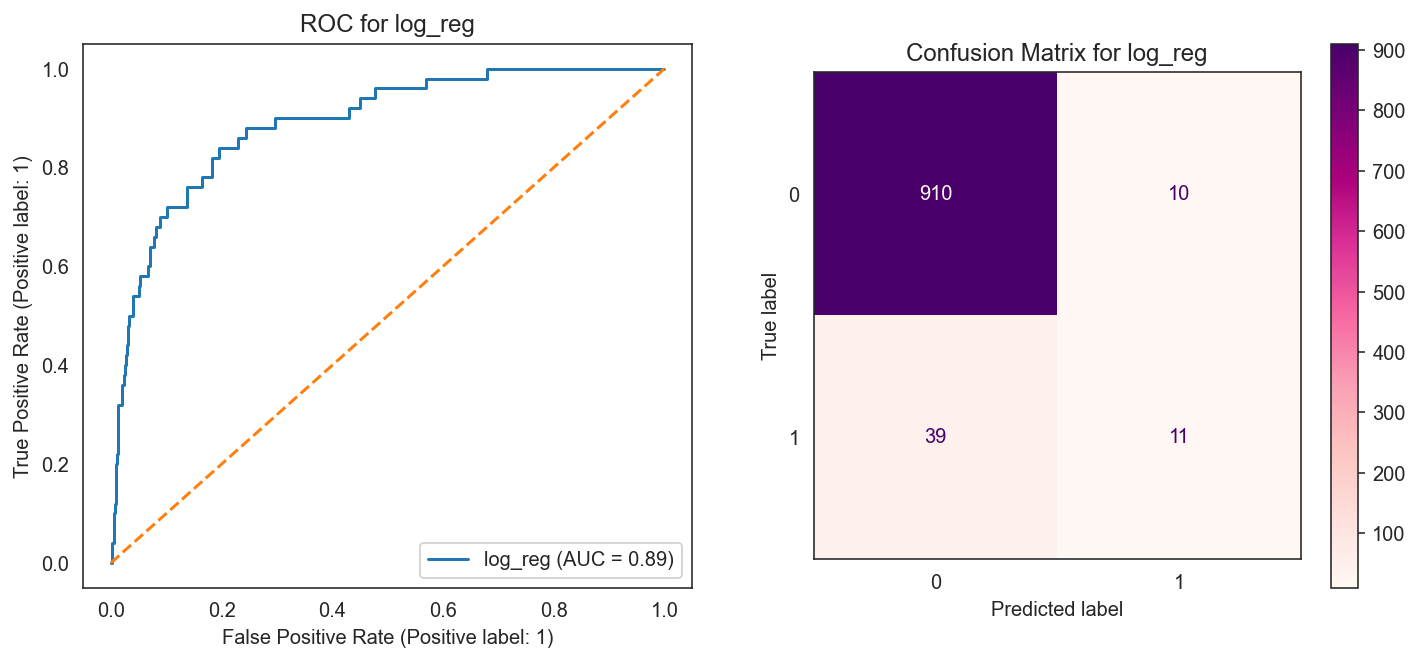

In [51]:
metrics['log_reg'] = model_metrics('log_reg', lr_pipe, lr_params, X_train, X_test, 
                                   y_train, y_test, models, val_preds_df)
pd.DataFrame(metrics)

### KNeighborsClassifier

In [52]:
# Creating a pipeline model for StandardScaler, SMOTE and Random Forest
knn_pipe = Pipeline([
        ('ss', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])
# Paratmeters
knn_params = {'knn__n_neighbors': [3, 5, 7],
              'knn__weights': ['uniform', 'distance']}

k_neighbor->Best params: {'knn__n_neighbors': 7, 'knn__weights': 'uniform'}


,log_reg,k_neighbor
01 Train score,0.9658,0.9666
02 Test score,0.9495,0.9206
03 Score diff,0.0163,0.046
04 Train recall,0.9472,0.9680
05 Test recall,0.2200,0.1200
06 F1 score,0.3099,0.1348
07 Precision,0.5238,0.1538
08 Specificity,0.9891,0.9641
09 Sensitivity,0.2200,0.1200
10 True Negatives,910,887


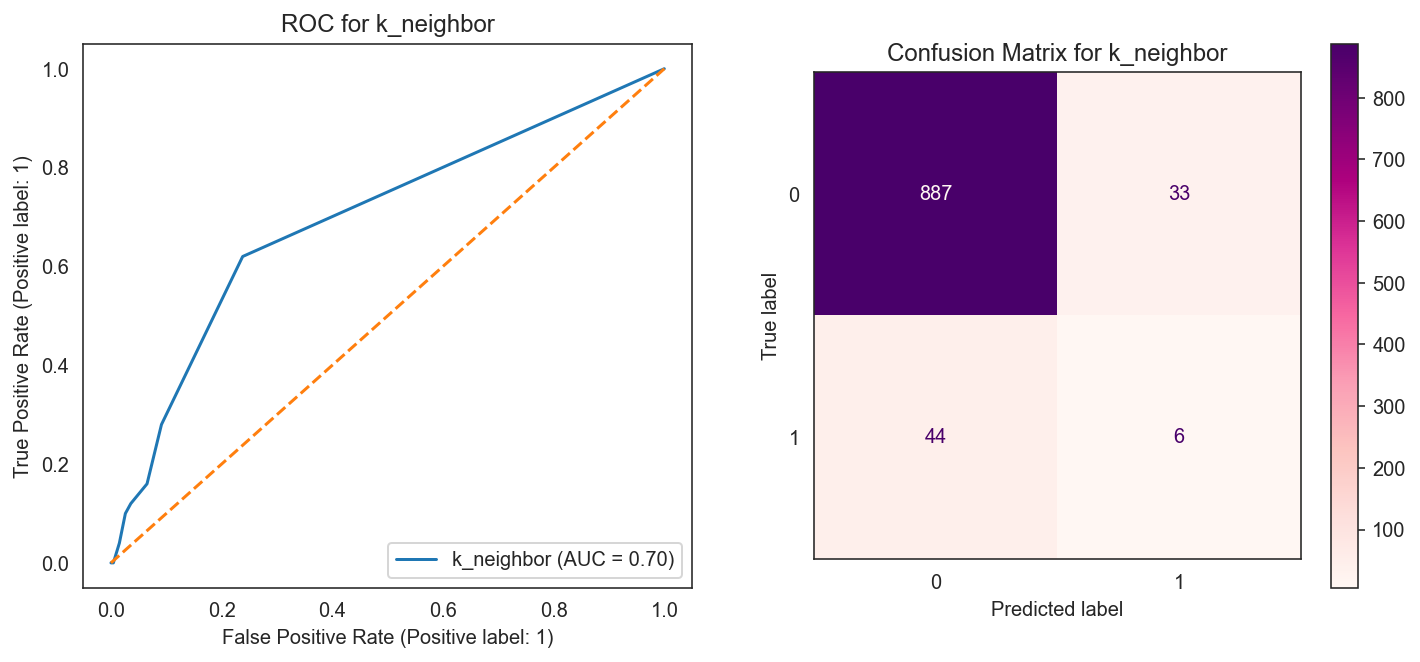

In [53]:
metrics['k_neighbor'] = model_metrics('k_neighbor', knn_pipe, knn_params, X_train, X_test, 
                                         y_train, y_test, models, val_preds_df)
pd.DataFrame(metrics)

### Random Forest

In [54]:
# Creating a pipeline model for StandardScaler, SMOTE and Random Forest
rf_pipe = Pipeline([
        ('ss', StandardScaler()),
        ('rf', RandomForestClassifier(random_state=RS))
    ])
# Paratmeters
rf_params = {
    'rf__max_depth': [1, 3],
    'rf__n_estimators': [100, 150]
}

random_forest->Best params: {'rf__max_depth': 3, 'rf__n_estimators': 150}


,log_reg,k_neighbor,random_forest
01 Train score,0.9658,0.9666,0.8025
02 Test score,0.9495,0.9206,0.7165
03 Score diff,0.0163,0.046,0.086
04 Train recall,0.9472,0.9680,0.9155
05 Test recall,0.2200,0.1200,0.7800
06 F1 score,0.3099,0.1348,0.2210
07 Precision,0.5238,0.1538,0.1287
08 Specificity,0.9891,0.9641,0.7130
09 Sensitivity,0.2200,0.1200,0.7800
10 True Negatives,910,887,656


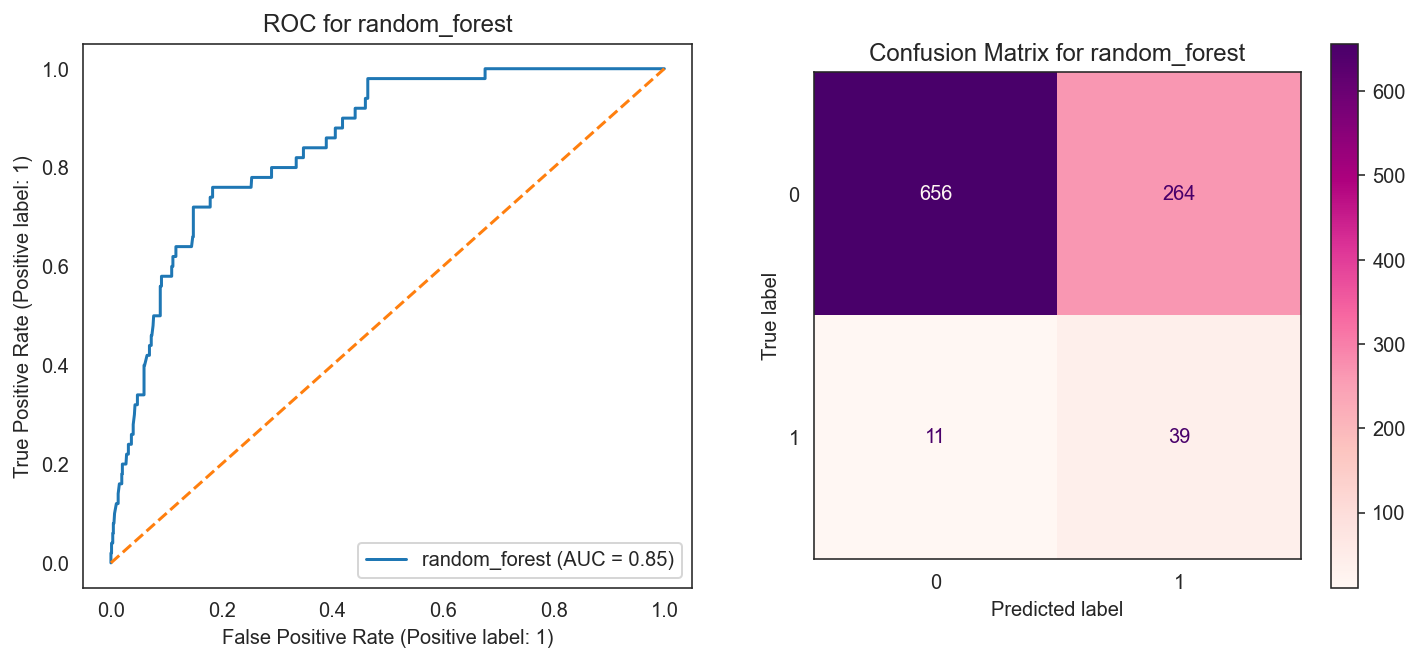

In [55]:
metrics['random_forest'] = model_metrics('random_forest', rf_pipe, rf_params, X_train, X_test, 
                                         y_train, y_test, models, val_preds_df)
pd.DataFrame(metrics)

### Extra Tree

In [56]:
# Creating a pipeline model for StandardScaler, SMOTE and Extra Trees
et_pipe = Pipeline([
        ('ss', StandardScaler()),
        ('et', ExtraTreesClassifier(random_state=RS, n_jobs=-1))
    ])
# Parameters
et_params = {'et__n_estimators': [500],
             'et__min_samples_split': [2],
             'et__min_samples_leaf': [5],
             'et__ccp_alpha': [0]}

extra_trees->Best params: {'et__ccp_alpha': 0, 'et__min_samples_leaf': 5, 'et__min_samples_split': 2, 'et__n_estimators': 500}


,log_reg,k_neighbor,random_forest,extra_trees
01 Train score,0.9658,0.9666,0.8025,0.9251
02 Test score,0.9495,0.9206,0.7165,0.8763
03 Score diff,0.0163,0.046,0.086,0.0488
04 Train recall,0.9472,0.9680,0.9155,0.9570
05 Test recall,0.2200,0.1200,0.7800,0.5000
06 F1 score,0.3099,0.1348,0.2210,0.2941
07 Precision,0.5238,0.1538,0.1287,0.2083
08 Specificity,0.9891,0.9641,0.7130,0.8967
09 Sensitivity,0.2200,0.1200,0.7800,0.5000
10 True Negatives,910,887,656,825


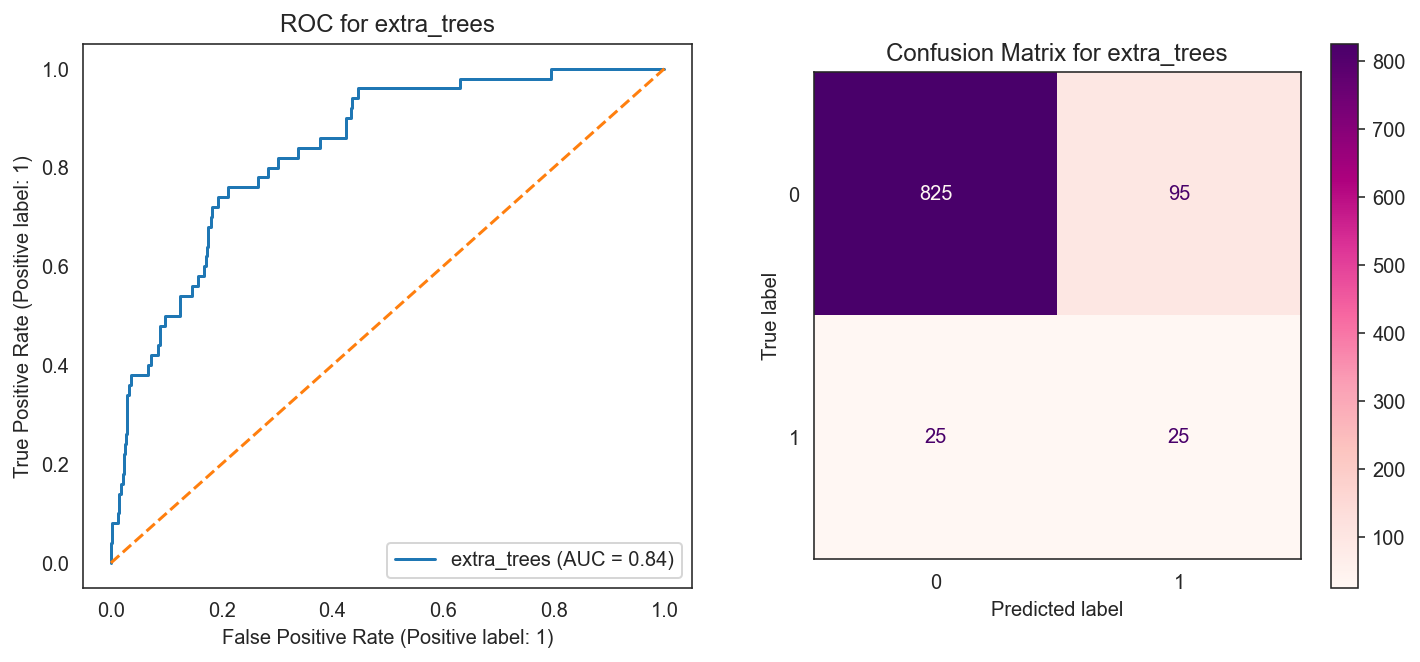

In [57]:
metrics['extra_trees'] = model_metrics('extra_trees', et_pipe, et_params, X_train, X_test, 
                                       y_train, y_test, models, val_preds_df)
pd.DataFrame(metrics)

### GradientBoostingClassifier

In [58]:
# pipeline
gboost_pipe = Pipeline([
        ('ss', StandardScaler()),
        ('gboost', GradientBoostingClassifier(random_state=RS))
])
# Parameters
gboost_params = {
    'gboost__n_estimators': [80, 100, 120, 150],
    'gboost__max_depth': [1, 2, 3],
    'gboost__min_samples_split': [2, 4],
    'gboost__min_samples_leaf': [1, 2]
}

gboost->Best params: {'gboost__max_depth': 3, 'gboost__min_samples_leaf': 2, 'gboost__min_samples_split': 2, 'gboost__n_estimators': 150}


,log_reg,k_neighbor,random_forest,extra_trees,gboost
01 Train score,0.9658,0.9666,0.8025,0.9251,0.9320
02 Test score,0.9495,0.9206,0.7165,0.8763,0.9041
03 Score diff,0.0163,0.046,0.086,0.0488,0.0279
04 Train recall,0.9472,0.9680,0.9155,0.9570,0.9445
05 Test recall,0.2200,0.1200,0.7800,0.5000,0.6000
06 F1 score,0.3099,0.1348,0.2210,0.2941,0.3922
07 Precision,0.5238,0.1538,0.1287,0.2083,0.2913
08 Specificity,0.9891,0.9641,0.7130,0.8967,0.9207
09 Sensitivity,0.2200,0.1200,0.7800,0.5000,0.6000
10 True Negatives,910,887,656,825,847


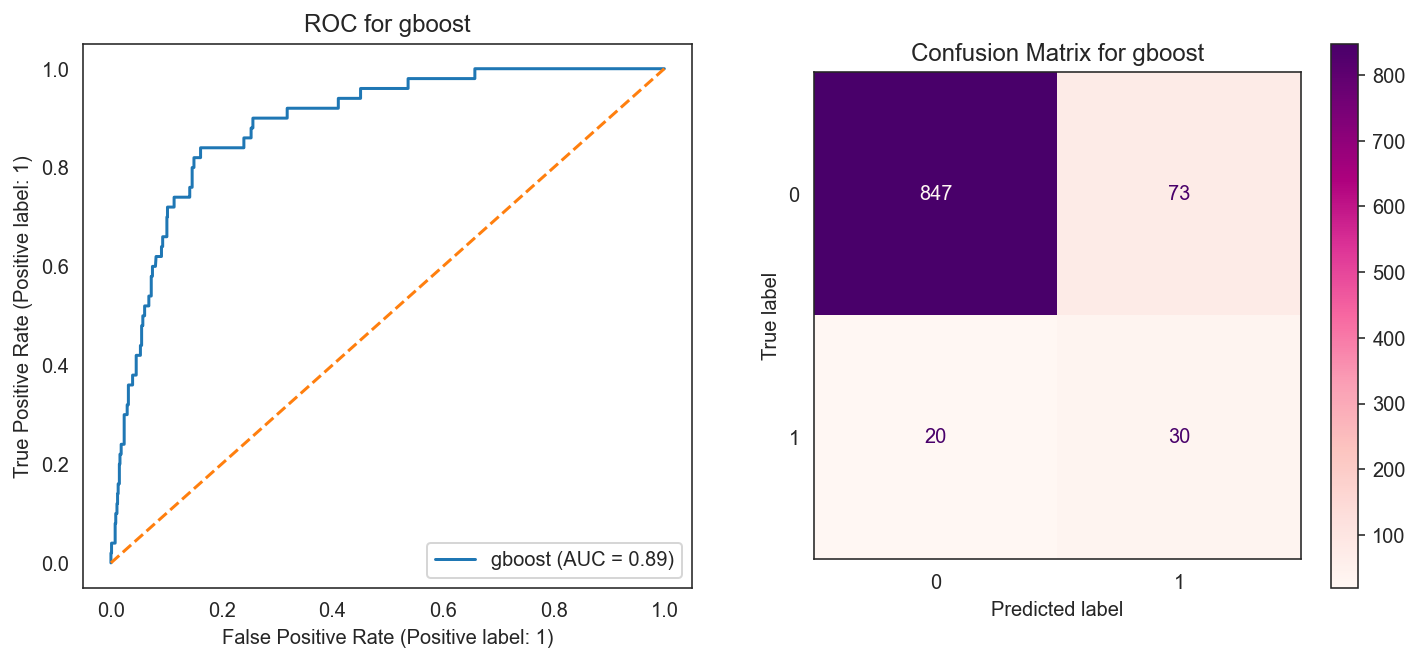

In [59]:
metrics['gboost'] = model_metrics('gboost', gboost_pipe, gboost_params, X_train, X_test, 
                                   y_train, y_test, models, val_preds_df)
pd.DataFrame(metrics)

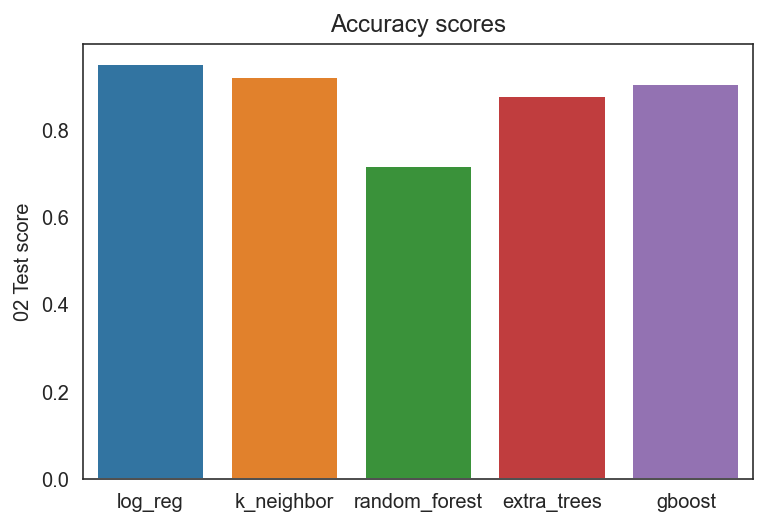

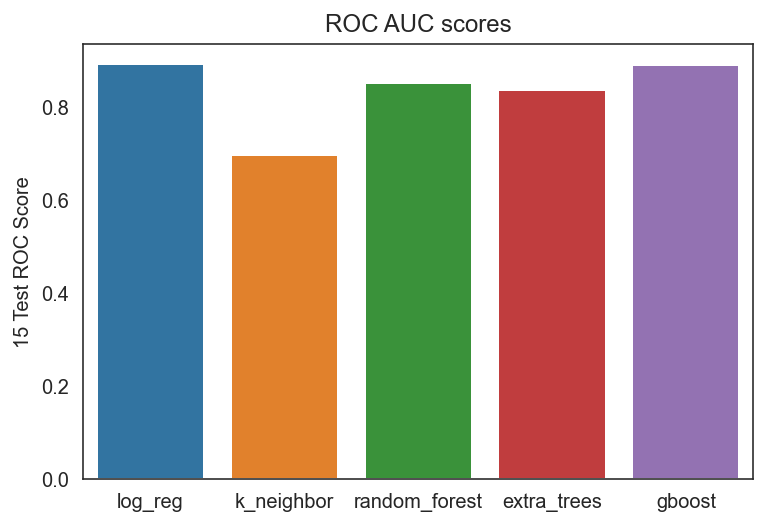

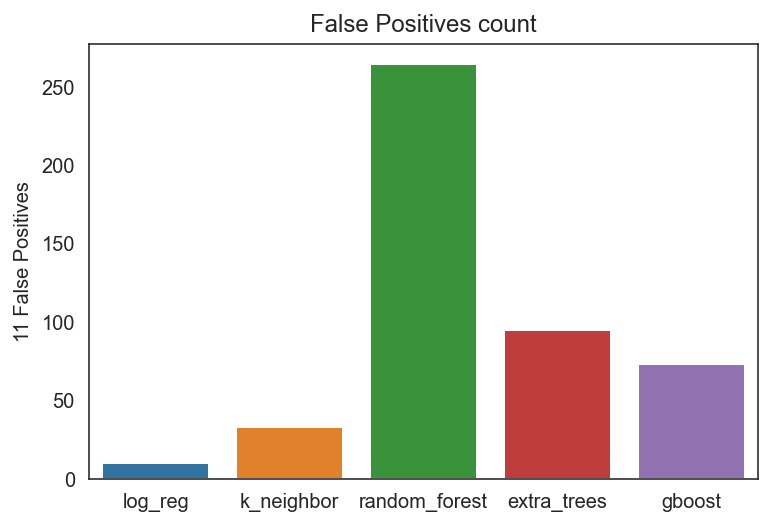

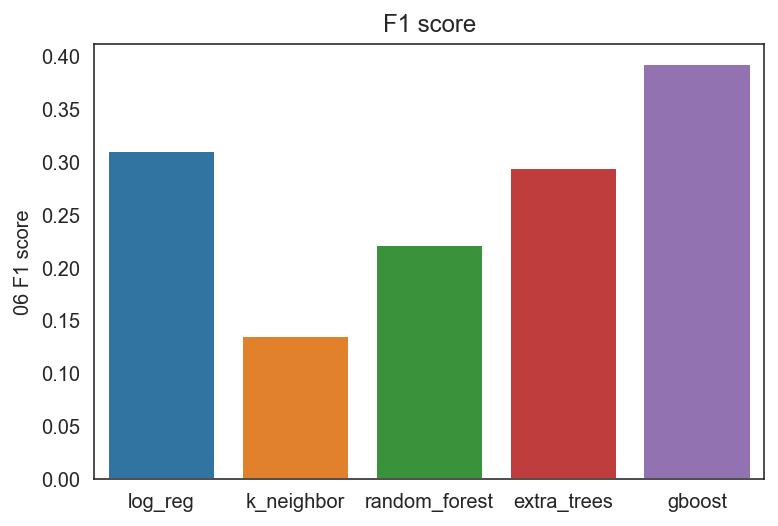

In [60]:
metrics_df = pd.DataFrame(metrics).T
cols = {'02 Test score': 'Accuracy scores', 
        '15 Test ROC Score': 'ROC AUC scores', 
        '11 False Positives': 'False Positives count', 
        '06 F1 score': 'F1 score'}

for col in cols.keys():
    metrics_df[col] = metrics_df[col].astype('float')
    sns.barplot(x=metrics_df.index, y=col, data=metrics_df, ci=None);
    plt.title(cols[col])
    plt.show();

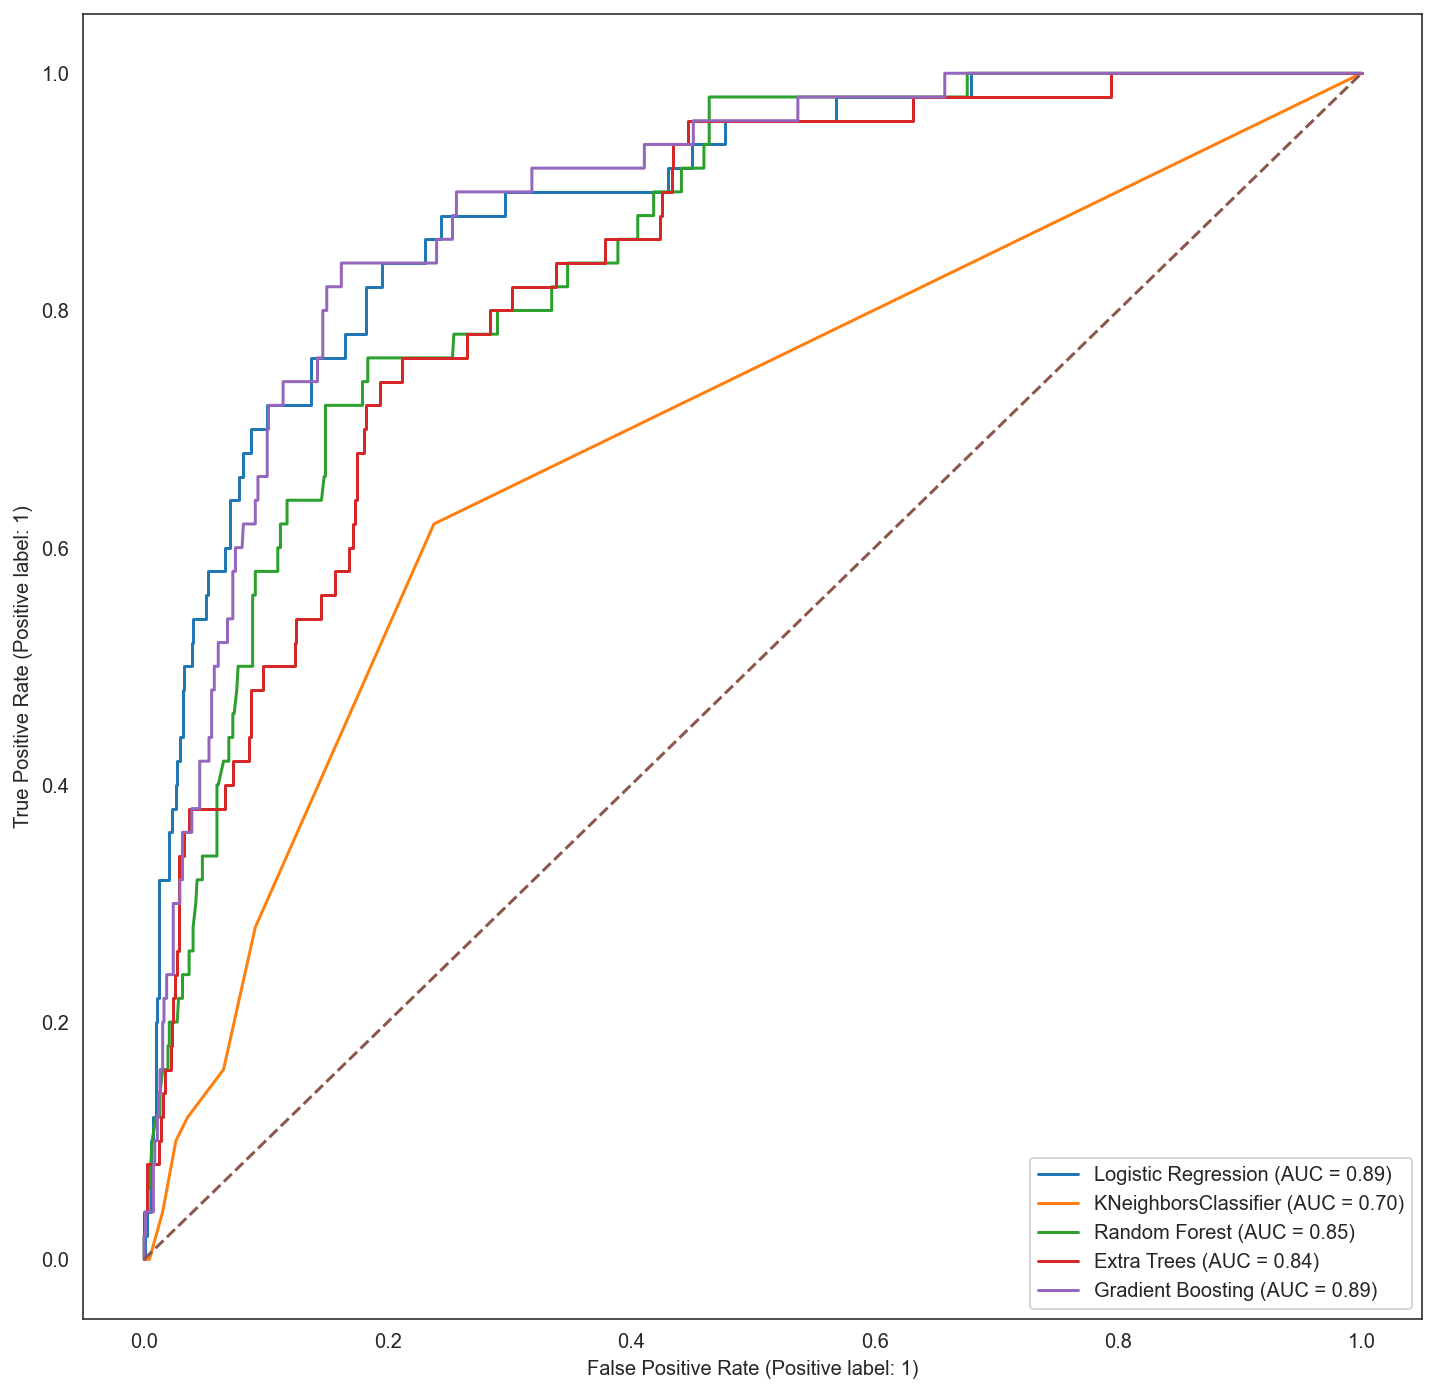

In [61]:
# Combine chart of ROC/AUC
fig, ax = plt.subplots(figsize=(12,12));
lr_plot = plot_roc_curve(models['log_reg'].best_estimator_, X_test, y_test, name='Logistic Regression',ax=ax);
knn_plot = plot_roc_curve(models['k_neighbor'].best_estimator_, X_test, y_test, name='KNeighborsClassifier',ax=ax);
rf_plot = plot_roc_curve(models['random_forest'].best_estimator_, X_test, y_test, name='Random Forest', ax=ax);
et_plot = plot_roc_curve(models['extra_trees'].best_estimator_, X_test, y_test, name='Extra Trees', ax=ax);
gb_plot = plot_roc_curve(models['gboost'].best_estimator_, X_test, y_test, name='Gradient Boosting', ax=ax);
plt.plot(np.linspace(0, 1, 200), np.linspace(0, 1, 200), label='baseline', linestyle='--');

### Model Selection and Feature Importance

#### Interpreting Gradient Boosting

In [62]:
gboost = GradientBoostingClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=150, random_state=42)
gboost.fit(X_train, y_train)

GradientBoostingClassifier(min_samples_leaf=2, n_estimators=150,
                           random_state=42)

In [63]:
imp_gboost = pd.DataFrame(gboost.feature_importances_,
                       index=X.columns,
                       columns=['weights']).sort_values(by='weights', ascending=False)

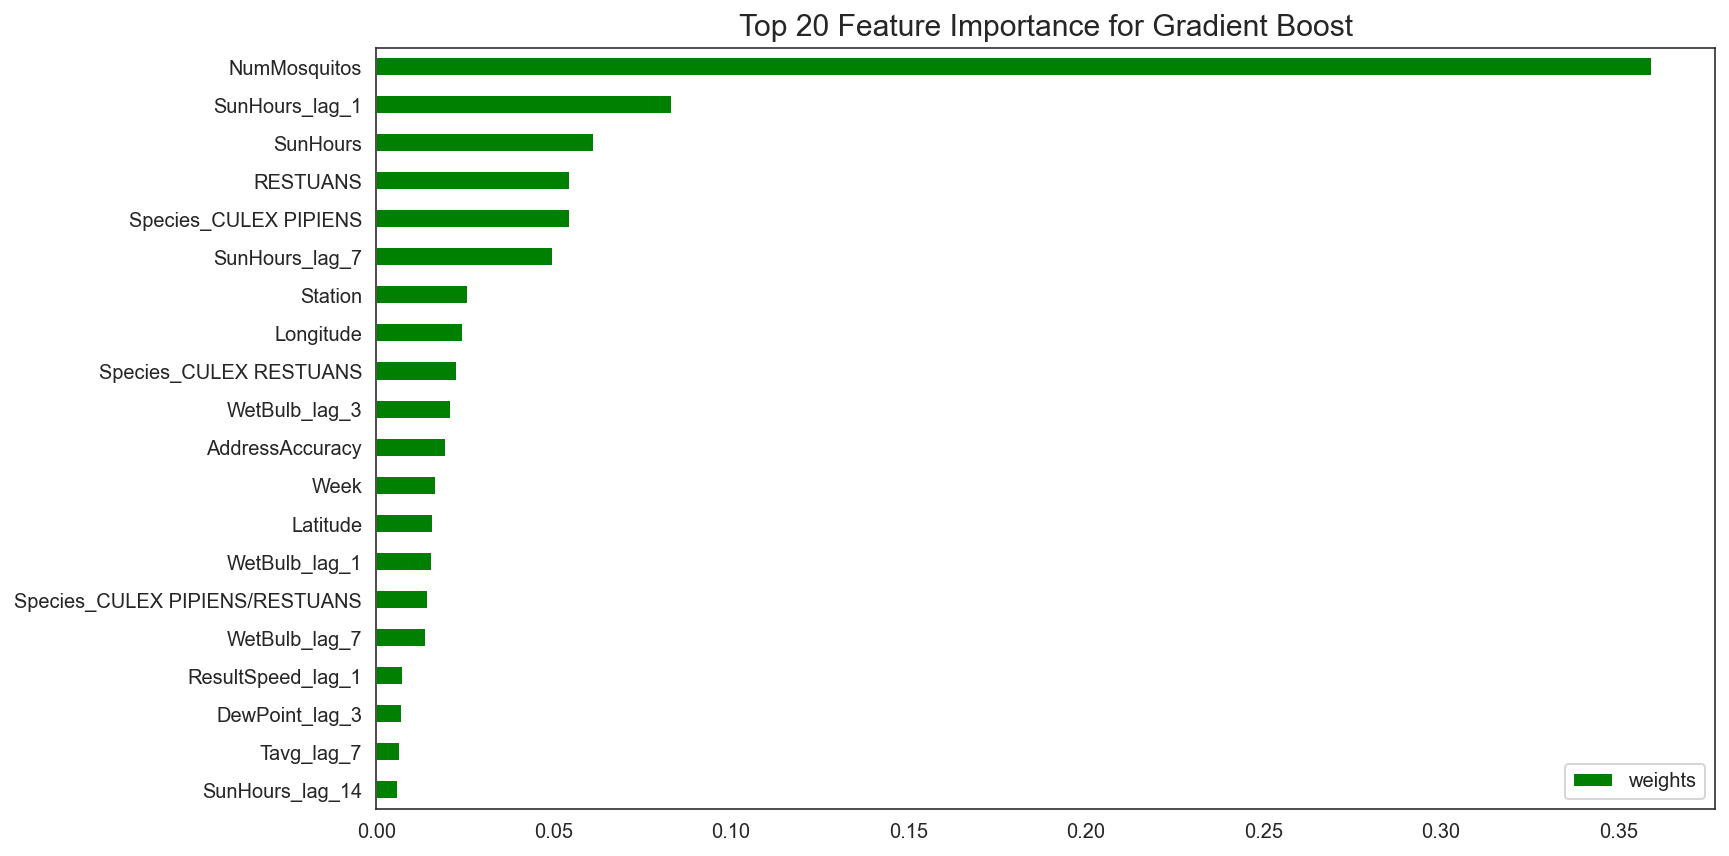

In [64]:
# Plot in bar chart
imp_gboost.head(20).plot(kind='barh', label=imp_gboost.columns[:20], figsize=(12,7), color='green')
plt.title('Top 20 Feature Importance for Gradient Boost', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

## Evaluation and Conceptual Understanding

We ran several models to analyse which was the most ideal model to predict if the mosquito would be infected for the West Nile Virus. Models Analysed:

- Logistic Regression
- K Neighbors Classifier
- Random Forest
- Extra Trees
- AdaBoost

We ran the models on historical data for the years of 2007, 2009, 2011, 2013, where we had recorded data such as, weather data, spray data, how many mosquitoes were caught in traps and how many of these were infected with the West Nile Virus. We did not compare the accuracy of this model to the baseline prediction since the data was heavily imbalanced in the first place (>95% of one class). The imbalances were dealt with using the SMOTE technique. The models' result were evaluated based on the ROC AUC score metric and the model that achieve the highest ROC score, was then used on data collected on 2008, 2010, 2012 and 2014, to predict which mosquitoes were positive for West Nile Virus. ROC refers to the receiver operating characteristic curve (i.e. probability curve), whereas AUC indicates the measure of the ability of the model to distinguish between classes. In this case, ROC Score tells us the probability of predicting a mosquito infected with the West Nile Virus, hence the highest score would mean the model holds the highest probability to make a right prediction. Also, in this analysis, the higher the AUC, the better the model is at distinguishing between mosquito traps with WNV present and WNV not present.

We also use F1 metric to eveluate our models. F1 score (also known as F-measure, or balanced F-score) is an error metric which measures model performance by calculating the harmonic mean of precision and recall for the minority positive class. To be more specific, F1 score can be interpreted as the model’s balanced ability to both capture positive cases (recall) and be accurate with the cases it does capture (precision). By taking F1 metric from our Logistic Regression model, the interpretation of this value is that on a scale from 0 (worst) to 1 (best), the model’s ability to both capture positive cases and be accurate with the cases it does capture is only 0.31.

The production model which we ended up with was one using the Gradient Boosting algorithm.

## Generate predictions for WnvPresent on Test dataset

In [65]:
test_weather_encoded_df.shape

(116293, 235)

In [66]:
test_weather_encoded_df = test_weather_encoded_df.drop(columns=['WnvPresent'])

In [68]:
# apply model on actual test data
wnv_present = gboost.predict(test_weather_encoded_df)

# add predictions to the test_df
test_weather_encoded_df['WnvPresent'] = wnv_present

# check the proportion of WnvPresent
test_weather_encoded_df['WnvPresent'].value_counts()

0    107877
1      8416
Name: WnvPresent, dtype: int64

In [69]:
# Generate Kaggle submission file
submission = pd.DataFrame({
        "Id": test_weather_encoded_df['Id'],
        "WnvPresent": wnv_present
    })

submission.to_csv('./output/kaggle_submission.csv', index=False)

## Kaggle Submission
<img src="./output/kaggle_submission.png" width="800"/>

## Cost-benefit Analysis

The cost of Zenivex E4 is $0.92 per acre (as shown in the screenshot below). Refer to the [reference](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_communities/news/2020/august/city-to-spray-insecticide-thursday-to-kill-mosquitoes0.html) for the spray effort in Chigago.

The entire city of Chicago has an area size of 606.60 km2. Chicago has very few water bodies, and the land area size totals to 588.98 km2 (145545 acres).

## Spray Pricing
<img src="./input/spray_pricing.png" width="800"/>

In [70]:
#The cost of spraying the full land size of Chicago  
chicago_spray_cost = 0.92 * 145545
chicago_spray_cost

133901.4

In [71]:
#As the effect of spraying lasts for 30 days, for a full-year coverage, spraying will need to be performed 12 times
chicago_spray_cost= chicago_spray_cost * 12
chicago_spray_cost

1606816.7999999998

It’s unrealistic to spray over a radius of 10,000ft. Instead, a 10% coverage would be more than enough, In this case, we are assuming 700ft of radius for spraying.

In [72]:
#Area size of each trap = πr**2 
#Radius of 700ft because spraying has a 300ft dispersement coverage
trap_area = 3.14 * 700**2
trap_area

1538600.0

In [73]:
#Convert sqft to acres
trap_area = trap_area/43560
trap_area

35.321395775941234

In [74]:
#Cost required for each trap = trap_area x zenivex cost
trap_cost = trap_area * 0.92
trap_cost

32.495684113865934

In [75]:
#Total cost = [cost of each trap] x [number of traps] x [number of sprayings]
#The model predicted 149 unique traps where the virus is present
total_cost = trap_cost * 149 * 12
total_cost

58102.28319559229

In [76]:
spray_savings = chicago_spray_cost - total_cost
spray_savings

1548714.5168044076

### Hospitalization and Lost Productivity

From 1999 through 2012, health care expenses and lost productivity in the US totalled up to $800 million.([Reference](https://www.sciencedaily.com/releases/2014/02/140210184713.htm))

Out of the 37,088 WNV cases, 1,529 (4%) died and an estimated 18,313 (49%) of the total cases were hospitalized.

Back in 2002, Chicago suffered its first, and most severe, WNV epidemic: 225 human cases were reported, including 22 fatalities.

Assuming only the initial costs and the cases with just fever (mean = $7,500), the estimated yearly hospitalization costs in Chicago are AT LEAST:

In [77]:
unit_cost=0.92
area=[]
area.append(145_500)
area.append(6_055)
area.append(606)
no_interval=13

In [78]:
biweekly_cost=[area[i]*unit_cost for i in range(len(area))]

In [79]:
annual_cost=[biweekly_cost[i]*no_interval for i in range(len(biweekly_cost))]

In [80]:
benefit=[]
benefit.append(7500*225)
benefit.append(7500*225*0.1) # 0.1 is population percentage of the densely populated communities 
benefit.append(7500*225*0.6)

In [81]:
cost_benefit=pd.DataFrame(annual_cost,columns=['cost'])

In [82]:
cost_benefit['benefit']=benefit

In [83]:
cost_benefit['index']=['Spray_level_1','Spray_level_2','Spray_level_3']
cost_benefit.set_index(['index'],inplace=True)

Text(0, 0.5, 'Annual_USD')

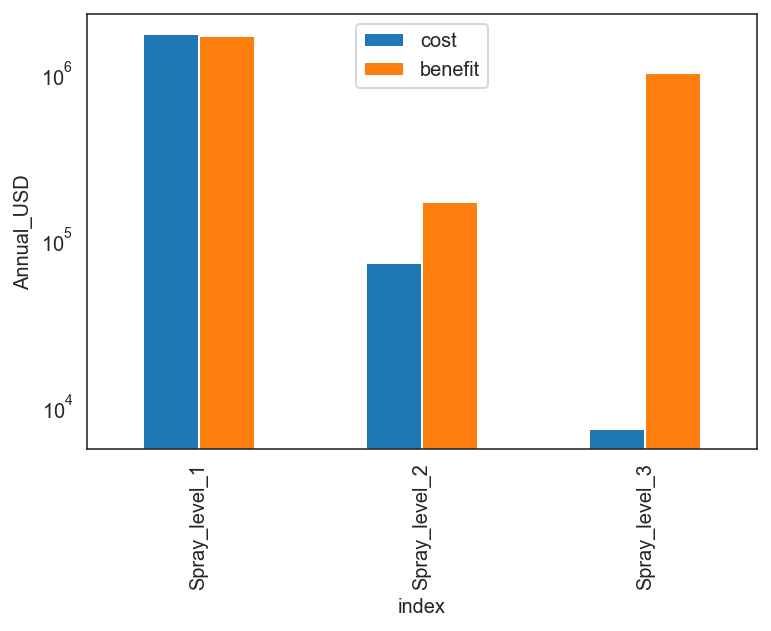

In [84]:
ax=cost_benefit.plot.bar()
ax.set_yscale('log')
ax.set_ylabel('Annual_USD')

Through our model, we are confident to predict 60% of the WNV (based on the recall score of 0.606). By deploying interventions to eradicate carrier mosquitos or to notify potential infected citizens for early treatment, we would be able to save ~$1,000,000 on initial hospitalization costs.

## Conclusion and Recommendations

Through this project, we gained many useful insights about the mosquito population in the Windy City and its relation to the epidemic of West Nile Virus (Wnv). Using the data on mosquito traps, weather and pesticide spraying, we were able to develop several models with tuned hyperparameters to classify whether Wnv is present or not. In the process of finding the best model for predicting the presence of Wnv, we found that the species type, the duration of the Sun, temperature, wind, humidity are consistently strong predictors across the models. The presence of Wnv is more prevalent when the sun has set. Another important factor to the presence of Wnv is the mosquito species, where we observed that culex pipiens and culex restuans mosquitoes are strong vectors of spreading the Wnv. In addition, research showed that mosquitoes flourish in moist, relatively warm environments and a less windy environment enables mosquitoes to navigate easily to feed on humans.

The production model which we ended up with was one using the Logistic Regression algorithm. It has a high AUC score and a Recall Score. We did not compare the accuracy of this model to the baseline prediction since the data was heavily imbalanced in the first place (>95% of one class). The imbalances were dealt with using the SMOTE technique.

Future work: include longer period of spray data in the modeling; include geospatial info in spray data; reduce percentage of class 0.